In [1]:
%load_ext autoreload
%autoreload 2
import barcoderegression
import pickle
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.ndimage
import tqdm.notebook
import numpy.random as npr
import ipywidgets
import skimage
import skimage.feature 
import scipy.io
import cProfile

from barcoderegression.plotting import AnimAcross

import barcoderegression.plotting as bcp 
%matplotlib inline

def rbyc(A):
    mx=A.max()
    with AnimAcross(columns=A.shape[-1]) as a:
        for c in range(A.shape[-2]):
            for r in range(A.shape[-1]):
                ~a
                mappable=plt.imshow(A[:,:,c,r],vmin=0,vmax=mx)
                a.cb(mappable)
                plt.axis('off')
    
def rbycs(*args):
    def go(i):
        rbyc(args[i])
    ipywidgets.interact(go,i=list(range(len(args))))
    
def frames(model):
    frame_loadings=model.frame_loadings()
    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(frame_loadings[:,:,j]))
            plt.axis('off')

def spatials(model,spdims,blurred=True):
    F = model.F_scaled(blurred=blurred)

    with AnimAcross() as a:
        for j in range(model.J):
            a(j)  
            a.cb(plt.imshow(F[:,j].reshape(spdims)))

# load dat

In [2]:
with open('/home/jovyan/work/Documents/research/data/barseq/barseq.pkl','rb') as f:
    X=pickle.load(f)[:,:,650:830,1300:1500].astype(np.float32)
    R,C=X.shape[:2]
    X=np.transpose(X,[2,3,0,1])
basecalls=sp.io.loadmat('/home/jovyan/work/Documents/research/data/barseq/basecalls.mat')
goldcoords = basecalls['lroi1']-1
goldidx = basecalls['id21'][:, 0].astype(int) - 1

with open("example.pkl",'rb') as f:
    example=pickle.load(f)
    B=example['barcode'].astype(np.bool)
    M=np.prod(X.shape[:-2])
    
spdims=X.shape[:2]
Xrav=X.reshape((-1,R,C))

# profile

In [40]:
K=barcoderegression.blurkernels.NoBlur()
# K=barcoderegression.blurkernels.ContiguousBlur(spdims,[3,3])
model2=barcoderegression.parameters.Model(
    B,
    K,
    M=M,
    rho=np.ones(C)*.05,
    lam=.1)



In [41]:
model2.update_F(Xrav)

In [42]:
cProfile.run('model2.update_F(Xrav)')

         133 function calls in 0.129 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(einsum)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(sum)
        1    0.000    0.000    0.129    0.129 <string>:1(<module>)
       82    0.001    0.000    0.001    0.000 blurkernels.py:16(__matmul__)
        1    0.000    0.000    0.000    0.000 einsumfunc.py:1004(einsum)
        6    0.000    0.000    0.000    0.000 einsumfunc.py:995(_einsum_dispatcher)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2087(_sum_dispatcher)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2092(sum)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:73(_wrapreduction)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:74(<dictcomp>)
        1    0.000    0.000    0.001    0.001 helpers.py:15(phasing)
  

{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [ ]:

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F'])
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F','alpha','b','a','rho','varphi'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')

lossinfo=model2.loss(Xrav)
print('final perpix reconstruction loss',lossinfo['reconstruction']/(R*C*M))
print('final perpix L1 loss',model2.lam*lossinfo['l1']/(R*C*M))
print('final loss',lossinfo['loss'])

In [ ]:
# model2=model.copy()
model2=barcoderegression.parameters.Model(B,model.K,M=model.M,lam=model.lam)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(100)):
    trainer.update(nms=['F','varphi','alpha','rho','a','b'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')
plt.axhline(bestloss,color='black')

lossinfo=model2.loss(Xrav)
print('final reconstruction loss per obs',lossinfo['reconstruction']/model2.nobs)
print('final L1 loss perobs',model2.lam*lossinfo['l1']/model2.nobs)
print('final loss',lossinfo['loss'])

bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

790 1385


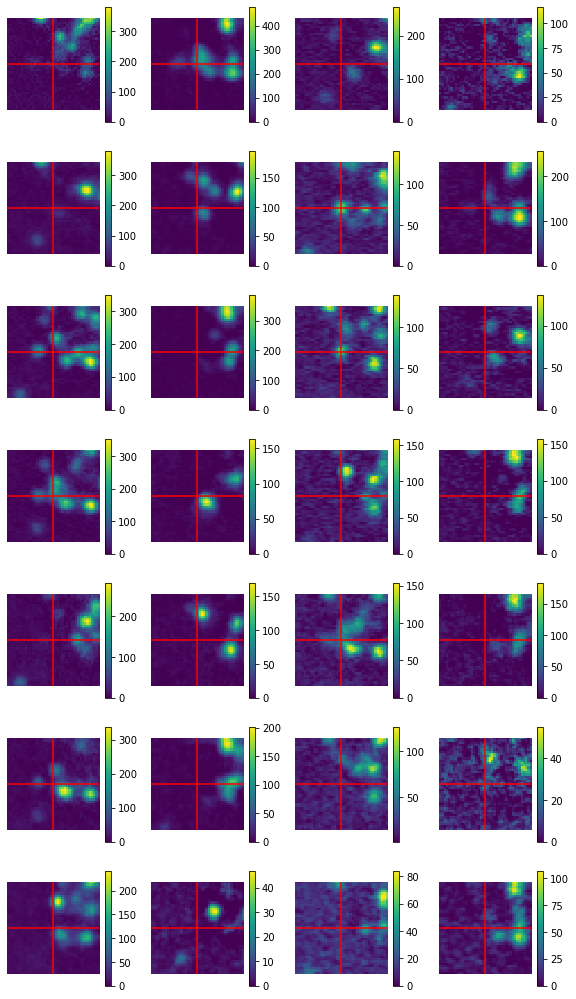

In [54]:


# x=npr.randint(0,X.shape[0])
# y=npr.randint(0,X.shape[1])
# x=88
# y=44

# x=88
# y=98

x,y=790, 1385
# x,y= 1385,790

print(x,y)
radius=20
st=np.max([[0,0],[x-radius,y-radius]],axis=0)
center = np.r_[x,y]-st
en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
with AnimAcross(columns=C,sz=2) as a:
    for r in range(R):
        for c in range(C):
            ~a
            a.cb(plt.imshow(X[sl+(r,c)]))
            plt.axhline(center[0],color='red')
            plt.axvline(center[1],color='red')
            plt.axis("off")  

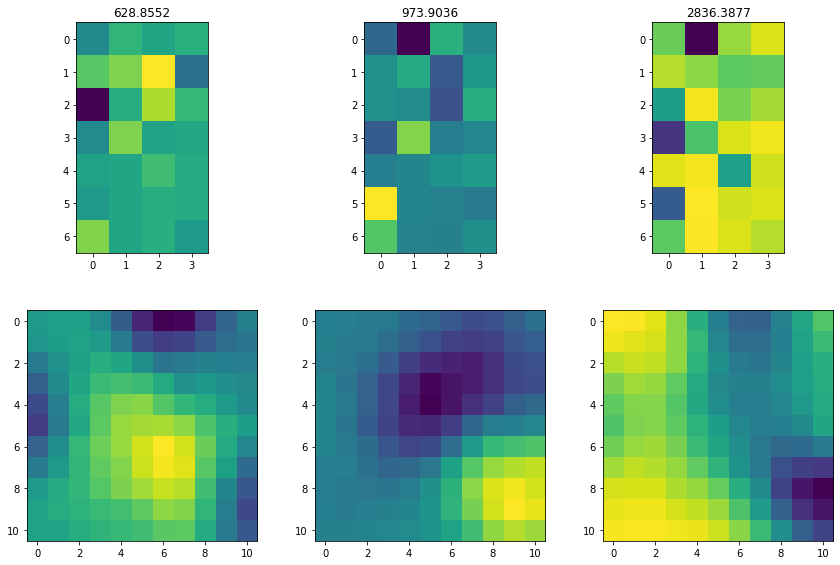

In [49]:
foo=X[sl].copy()
foo=foo.reshape((-1,R*C))
U,e,V = sp.sparse.linalg.svds(foo,3)
V=V.T
with barcoderegression.plotting.AnimAcross() as a:
    for i in range(V.shape[1]):
        a(e[i])
        plt.imshow(V[:,i].reshape((R,C)))
        
        
    for i in range(V.shape[1]):
        ~a
        plt.imshow(U[:,i].reshape(X[sl].shape[:2]))

790 1385


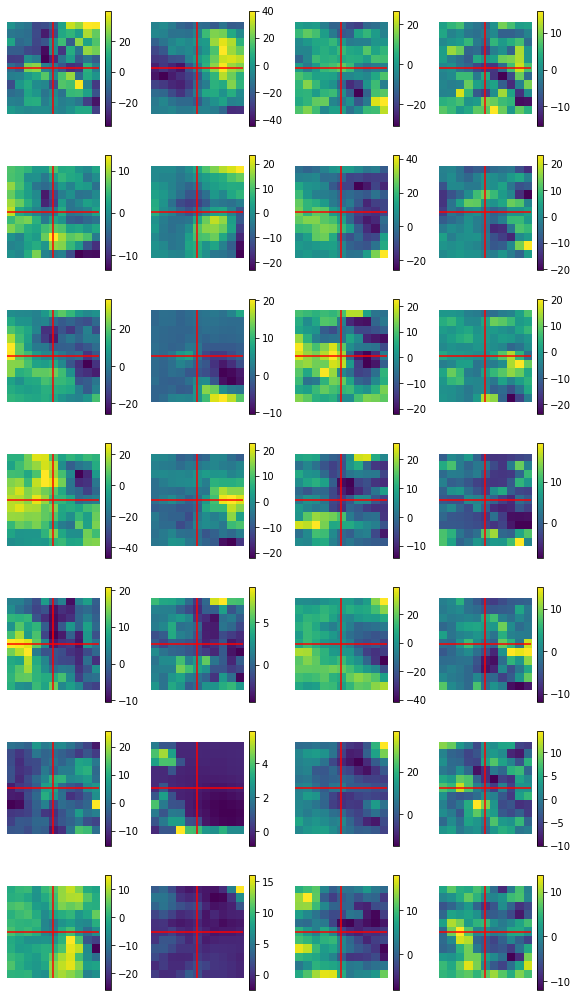

In [52]:
recon=(U@np.diag(e)@V.T).reshape(X[sl].shape)

# x=npr.randint(0,X.shape[0])
# y=npr.randint(0,X.shape[1])
# x=88
# y=44

# x=88
# y=98

x,y=790, 1385
# x,y= 1385,790

print(x,y)
radius=5
st=np.max([[0,0],[x-radius,y-radius]],axis=0)
center = np.r_[x,y]-st
en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
with AnimAcross(columns=C,sz=2) as a:
    for r in range(R):
        for c in range(C):
            ~a
            a.cb(plt.imshow(X[sl+(r,c)]-recon[:,:,r,c]))
            plt.axhline(center[0],color='red')
            plt.axvline(center[1],color='red')
            plt.axis("off")  

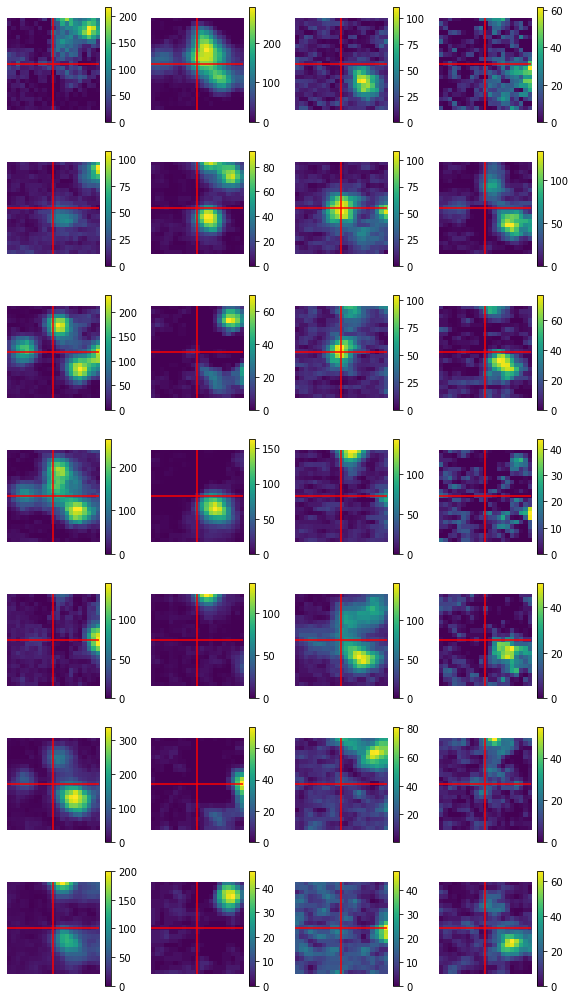

In [36]:


# x=npr.randint(0,X.shape[0])
# y=npr.randint(0,X.shape[1])
# x=88
# y=44

# x=88
# y=98

# x,y=790, 1385
# x,y= 1385,790

# print(x,y)
# radius=10
# st=np.max([[0,0],[x-radius,y-radius]],axis=0)
# center = np.r_[x,y]-st
# en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
# sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
with AnimAcross(columns=C,sz=2) as a:
    for r in range(R):
        for c in range(C):
            ~a
            a.cb(plt.imshow(X[sl+(r,c)]))
            plt.axhline(center[0],color='red')
            plt.axvline(center[1],color='red')
            plt.axis("off") 